# Analysis of LLM Judgments by Prompt Type

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
from pathlib import Path

sns.set_style("whitegrid")

In [2]:
def load_jsonl(path):
    data = []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))
    return pd.DataFrame(data)

In [3]:
runs_dir = Path('runs')

judgments_df = load_jsonl(runs_dir / 'judgments_20260124_173730.jsonl')
judgments_df['dataset'] = 'Deep Facts'

unans_judgments_df = load_jsonl(runs_dir / 'unanswerable_judgments_20260124_182623.jsonl')
unans_judgments_df['dataset'] = 'Unanswerable'

math_35turbo_judgments_df = load_jsonl(runs_dir / 'math_judgments_20260124_161958.jsonl')
math_35turbo_judgments_df['dataset'] = 'Math (GPT-3.5-Turbo)'

math_4omini_judgments_df = load_jsonl(runs_dir / 'math_judgments_20260124_162527.jsonl')
math_4omini_judgments_df['dataset'] = 'Math (GPT-4o-mini)'

## Summary Statistics by Prompt Variant

In [4]:
def create_summary_by_prompt(df, dataset_name):
    summary = df.groupby(['prompt_variant', 'judgment']).size().unstack(fill_value=0)
    summary['Total'] = summary.sum(axis=1)
    
    for col in summary.columns[:-1]:
        summary[f'{col}_pct'] = (summary[col] / summary['Total'] * 100).round(1)
    
    summary['Dataset'] = dataset_name
    return summary.reset_index()

summary_deep = create_summary_by_prompt(judgments_df, 'Deep Facts')
summary_unans = create_summary_by_prompt(unans_judgments_df, 'Unanswerable')
summary_math35 = create_summary_by_prompt(math_35turbo_judgments_df, 'Math (GPT-3.5-Turbo)')
summary_math4o = create_summary_by_prompt(math_4omini_judgments_df, 'Math (GPT-4o-mini)')

print("Deep Facts:")
display(summary_deep)
print("\nUnanswerable:")
display(summary_unans)
print("\nMath (GPT-3.5-Turbo):")
display(summary_math35)
print("\nMath (GPT-4o-mini):")
display(summary_math4o)

Deep Facts:


judgment,prompt_variant,ABSTAIN,CORRECT,HALLUCINATION,Total,ABSTAIN_pct,CORRECT_pct,HALLUCINATION_pct,Dataset
0,baseline,0,19,11,30,0.0,63.3,36.7,Deep Facts
1,confident,0,19,11,30,0.0,63.3,36.7,Deep Facts
2,honest,16,14,0,30,53.3,46.7,0.0,Deep Facts



Unanswerable:


judgment,prompt_variant,ABSTAIN,HALLUCINATION,Total,ABSTAIN_pct,HALLUCINATION_pct,Dataset
0,baseline,29,1,30,96.7,3.3,Unanswerable
1,confident,21,9,30,70.0,30.0,Unanswerable
2,honest,30,0,30,100.0,0.0,Unanswerable



Math (GPT-3.5-Turbo):


judgment,prompt_variant,ABSTAIN,CORRECT,HALLUCINATION,Total,ABSTAIN_pct,CORRECT_pct,HALLUCINATION_pct,Dataset
0,math_baseline,0,11,19,30,0.0,36.7,63.3,Math (GPT-3.5-Turbo)
1,math_confident,0,5,25,30,0.0,16.7,83.3,Math (GPT-3.5-Turbo)
2,math_honest,3,8,19,30,10.0,26.7,63.3,Math (GPT-3.5-Turbo)



Math (GPT-4o-mini):


judgment,prompt_variant,CORRECT,HALLUCINATION,Total,CORRECT_pct,HALLUCINATION_pct,Dataset
0,math_baseline,22,8,30,73.3,26.7,Math (GPT-4o-mini)
1,math_confident,20,10,30,66.7,33.3,Math (GPT-4o-mini)
2,math_honest,23,7,30,76.7,23.3,Math (GPT-4o-mini)


## Judgment Distribution by Prompt Variant

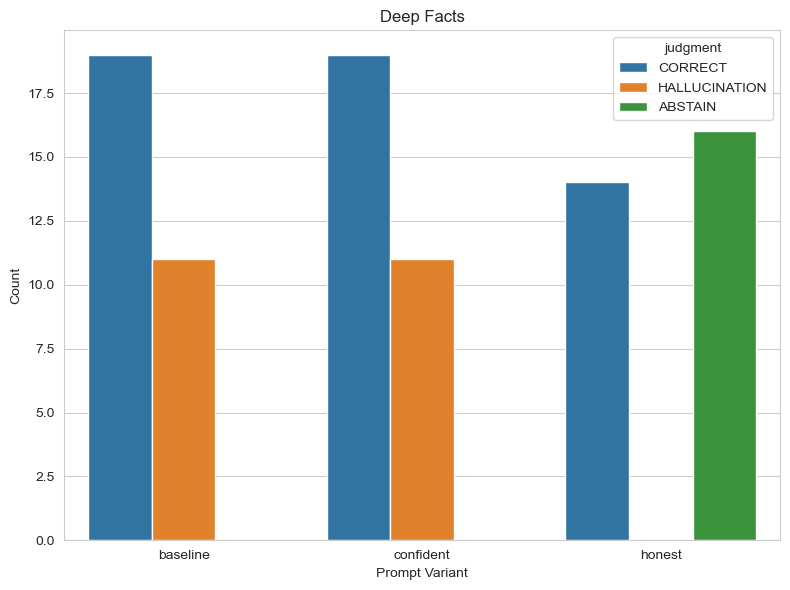

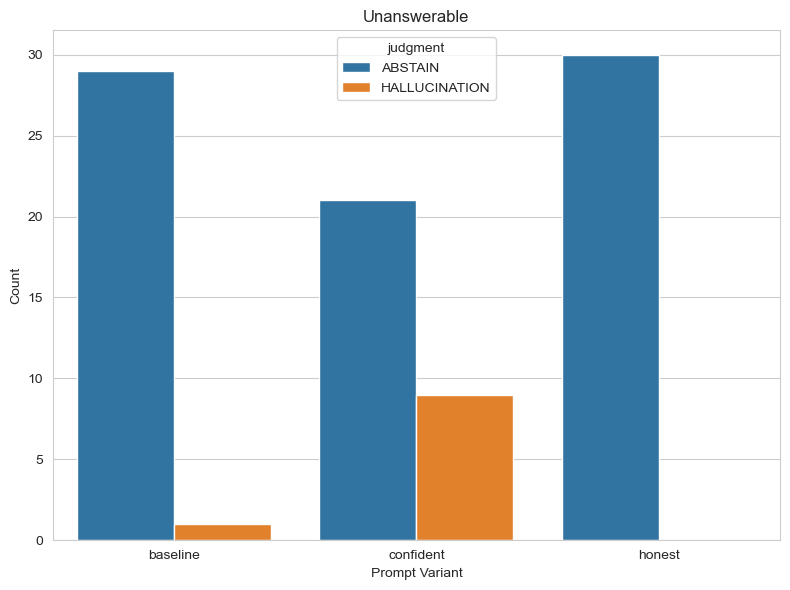

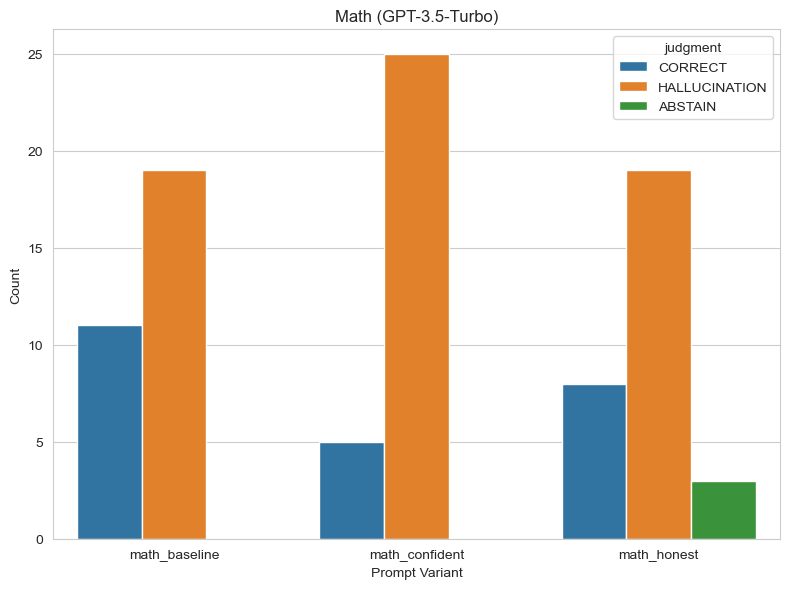

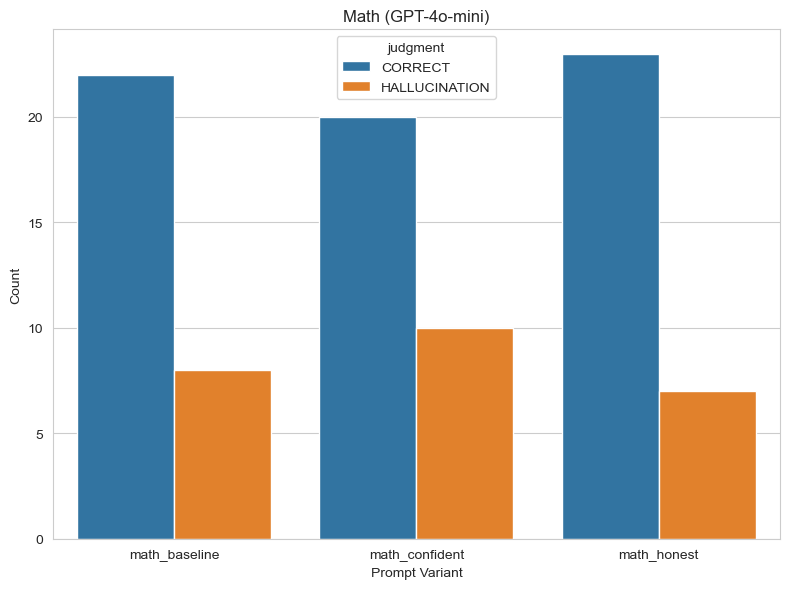

In [5]:
import os
os.makedirs('img', exist_ok=True)

datasets = [
    (judgments_df, 'Deep Facts', 'deep_facts'),
    (unans_judgments_df, 'Unanswerable', 'unanswerable'),
    (math_35turbo_judgments_df, 'Math (GPT-3.5-Turbo)', 'math_gpt35turbo'),
    (math_4omini_judgments_df, 'Math (GPT-4o-mini)', 'math_gpt4omini')
]

for df, title, filename in datasets:
    fig, ax = plt.subplots(figsize=(8, 6))
    plot_data = df.groupby(['prompt_variant', 'judgment']).size().reset_index(name='count')
    sns.barplot(data=plot_data, x='prompt_variant', y='count', hue='judgment', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Prompt Variant')
    ax.set_ylabel('Count')
    plt.tight_layout()
    plt.savefig(f'img/{filename}_by_prompt.png', dpi=300, bbox_inches='tight')
    plt.show()

## Comparison Across Datasets

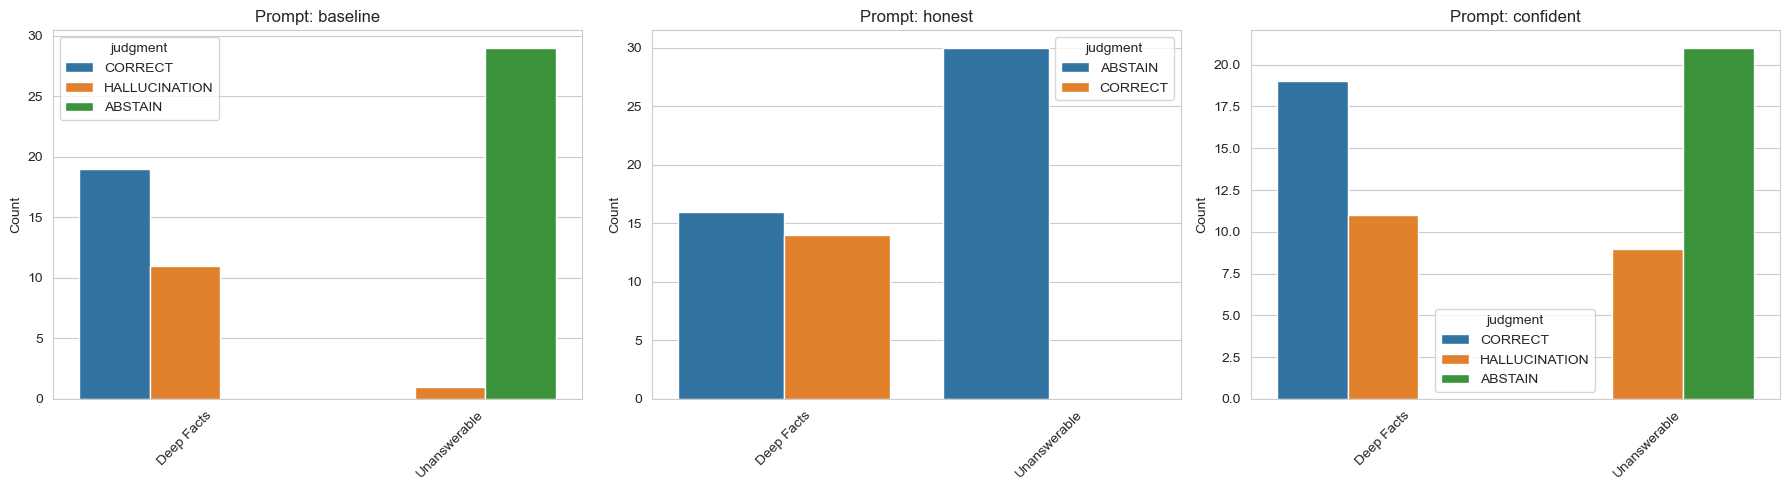

In [6]:
all_data = pd.concat([judgments_df, unans_judgments_df, math_35turbo_judgments_df, math_4omini_judgments_df])

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

variants = ['baseline', 'honest', 'confident']
for variant, ax in zip(variants, axes):
    variant_data = all_data[all_data['prompt_variant'] == variant]
    plot_data = variant_data.groupby(['dataset', 'judgment']).size().reset_index(name='count')
    
    sns.barplot(data=plot_data, x='dataset', y='count', hue='judgment', ax=ax)
    ax.set_title(f'Prompt: {variant}')
    ax.set_xlabel('')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Count Judgments by Category

In [7]:
# Count judgments for each dataset
judgments_counts = judgments_df['judgment'].value_counts()
unans_judgments_counts = unans_judgments_df['judgment'].value_counts()
math_35turbo_counts = math_35turbo_judgments_df['judgment'].value_counts()
math_4omini_counts = math_4omini_judgments_df['judgment'].value_counts()

print("Deep Facts Judgments:")
print(judgments_counts)
print(f"\nUnanswerable Judgments:")
print(unans_judgments_counts)
print(f"\nMath (GPT-3.5-Turbo) Judgments:")
print(math_35turbo_counts)
print(f"\nMath (GPT-4o-mini) Judgments:")
print(math_4omini_counts)

Deep Facts Judgments:
judgment
CORRECT          52
HALLUCINATION    22
ABSTAIN          16
Name: count, dtype: int64

Unanswerable Judgments:
judgment
ABSTAIN          80
HALLUCINATION    10
Name: count, dtype: int64

Math (GPT-3.5-Turbo) Judgments:
judgment
HALLUCINATION    63
CORRECT          24
ABSTAIN           3
Name: count, dtype: int64

Math (GPT-4o-mini) Judgments:
judgment
CORRECT          65
HALLUCINATION    25
Name: count, dtype: int64


## Summary Statistics

In [8]:
# Create summary table
summary_data = []

for name, df in [
    ('Deep Facts', judgments_df),
    ('Unanswerable', unans_judgments_df),
    ('Math (GPT-3.5-Turbo)', math_35turbo_judgments_df),
    ('Math (GPT-4o-mini)', math_4omini_judgments_df)
]:
    counts = df['judgment'].value_counts()
    total = len(df)
    summary_data.append({
        'Dataset': name,
        'Total': total,
        'CORRECT': counts.get('CORRECT', 0),
        'HALLUCINATION': counts.get('HALLUCINATION', 0),
        'ABSTAIN': counts.get('ABSTAIN', 0),
        'Correct %': f"{(counts.get('CORRECT', 0) / total * 100):.1f}%",
        'Hallucination %': f"{(counts.get('HALLUCINATION', 0) / total * 100):.1f}%",
        'Abstain %': f"{(counts.get('ABSTAIN', 0) / total * 100):.1f}%"
    })

summary_df = pd.DataFrame(summary_data)
print("\nSummary Statistics:")
display(summary_df)


Summary Statistics:


,Dataset,Total,CORRECT,HALLUCINATION,ABSTAIN,Correct %,Hallucination %,Abstain %
0,Deep Facts,90,52,22,16,57.8%,24.4%,17.8%
1,Unanswerable,90,0,10,80,0.0%,11.1%,88.9%
2,Math (GPT-3.5-Turbo),90,24,63,3,26.7%,70.0%,3.3%
3,Math (GPT-4o-mini),90,65,25,0,72.2%,27.8%,0.0%
